Techniques Demonstrated:
  1) Saving and Loading pre-trained Model Weights
  2) Saving and Loading NumPy objects (of images) - much faster!
  3) Early Stopping of CNN Training
  4) Saving and Loading Model Training history, and Visualizing (preserved) Model Training History
To-learn:
  1) Saving model probabilities in a nice way (for ensembling)

In [1]:
# Loading Common Packages for Our Team
import pickle as pickle
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
# import xgboost as xgb   # Fan Fei does not have XGBoost on Windows
import pickle as pickle
import cv2
import datetime as dt
print("------Imports complete-----")

------Imports complete-----


In [2]:
# Import Model Specific packages
from keras.preprocessing.image import img_to_array, load_img

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from multiprocessing import Pool, cpu_count

# callback for saving models, early stopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# for plotting model training history
import matplotlib.pyplot as plt

# os.chdir('C:/deep_learning') # This is where the input dataset is stored
# os.getcwd()
print("------Fan Fei's Imports Complete-----")

Using TensorFlow backend.


In [3]:
random_seed = 987654321
random.seed(random_seed)
np.random.seed(random_seed)

# train_path = "c:/deep_learning/kaggle/amazon/train/"
# test_path = "c:/deep_learning/kaggle/amazon/test/"
train_path = "f:/kaggle/amazon/train-jpg/"
test_path = "f:/kaggle/amazon/test-jpg/"
# train_path = "/mnt/f/kaggle/amazon/train-jpg/"
# test_path = "/mnt/f/kaggle/amazon/test-jpg/"

train = pd.read_csv("c:/deep_learning/kaggle/amazon/train_v2.csv")
# train = pd.read_csv("c:/deep_learning/kaggle/amazon/train_v2_short.csv")
test =  pd.read_csv("c:/deep_learning/kaggle/amazon/sample_submission_v2.csv")
# test =  pd.read_csv("c:/deep_learning/kaggle/amazon/sample_submission_v2_short.csv")

#Location for saving serialized objects
obj_save_path = "c:/deep_learning/kaggle/amazon/model/"
subm_output_path = "c:/deep_learning/kaggle/amazon/submissions/"
print("------Paths Built-----")

------Paths Built-----


In [4]:
def keras_image_prep(df, data_path, name, dim, labels):
    x_out = []
    y_out = []

    # flatten = lambda l: [item for sublist in l for item in sublist]
    # labels = list(set(flatten([l.split(' ') for l in df['tags'].values])))

    label_map = {l: i for i, l in enumerate(labels)}
    # inv_label_map = {i: l for l, i in label_map.items()}

    for image_name, tags in tqdm(df.values, miniters=1000):
        img = img_to_array(load_img(data_path + image_name + '.jpg', target_size=[dim,dim]))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        x_out.append(img)
        y_out.append(targets)
    
    x_out = np.array(x_out, np.float16) / 255.
    y_out = np.array(y_out, np.uint8)

    print(x_out.shape)
    print(y_out.shape)
    return x_out, y_out

In [5]:
input_dim = 32
labels = train['tags'].str.get_dummies(sep=' ').columns

In [18]:
# x_train, y_train = keras_image_prep(train, train_path, 'train', input_dim, labels)
# this is to provide a local validation F-score
split = 35000
# split = 80
# x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

# Save out the image NumPy to disk
# np.save('f:/kaggle/amazon/x_train.npy', x_train)
# np.save('f:/kaggle/amazon/y_train.npy', y_train)
# np.save('f:/kaggle/amazon/x_valid.npy', x_valid)
# np.save('f:/kaggle/amazon/y_valid.npy', y_valid)

# can use the following block after the image has been saved as NumPy
x_train = np.load('f:/kaggle/amazon/x_train.npy')
y_train = np.load('f:/kaggle/amazon/y_train.npy')
x_valid = np.load('f:/kaggle/amazon/x_valid.npy')
y_valid = np.load('f:/kaggle/amazon/y_valid.npy')

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_dim, input_dim, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [20]:
# Read in pre-trained weights - fast
model.load_weights(obj_save_path + "weights.best.hdf5")

In [21]:
# Compiling the model - fast
model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# Incorporate Callback features
# Checkpointing 
filepath= obj_save_path + "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Early Stopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=5, verbose=0, mode='auto') 

callbacks_list = [checkpoint, earlystop]

In [23]:
# the explicit split approach was taken so as to allow for a local validation
# model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

# Fit the model (Add history so that the history may be saved)
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=36,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=(x_valid, y_valid))

Train on 35000 samples, validate on 5479 samples
Epoch 1/36
35000/35000 [==============================] - 310s - loss: 0.1444 - acc: 0.9421 - val_loss: 0.1408 - val_acc: 0.9443
Epoch 2/36
35000/35000 [==============================] - 297s - loss: 0.1426 - acc: 0.9425 - val_loss: 0.1381 - val_acc: 0.9463
Epoch 3/36
35000/35000 [==============================] - 297s - loss: 0.1410 - acc: 0.9434 - val_loss: 0.1349 - val_acc: 0.9456
Epoch 4/36
35000/35000 [==============================] - 298s - loss: 0.1400 - acc: 0.9434 - val_loss: 0.1363 - val_acc: 0.9441
Epoch 5/36
35000/35000 [==============================] - 299s - loss: 0.1386 - acc: 0.9440 - val_loss: 0.1343 - val_acc: 0.9458
Epoch 6/36
35000/35000 [==============================] - 299s - loss: 0.1366 - acc: 0.9445 - val_loss: 0.1356 - val_acc: 0.9463
Epoch 7/36
35000/35000 [==============================] - 300s - loss: 0.1356 - acc: 0.9448 - val_loss: 0.1355 - val_acc: 0.9466
Epoch 8/36
35000/35000 [========================

In [24]:
# Local Validation Results
from sklearn.metrics import fbeta_score
p_valid = model.predict(x_valid, batch_size=128,verbose=2)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.87598782907


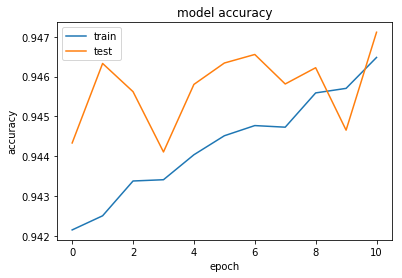

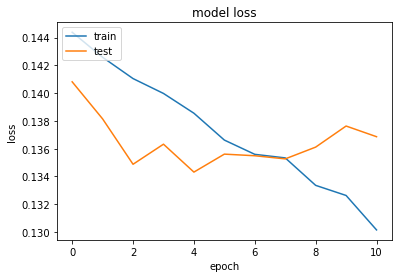

In [25]:
# Plot Training History

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# purge the x_train and y_train dataset, and read in the test images
x_train = []
y_train = []

# x_test, y_test = keras_image_prep(test, test_path, 'test', input_dim, labels)
# Save out the test image NumPy
# np.save('f:/kaggle/amazon/x_test.npy', x_test)
# np.save('f:/kaggle/amazon/y_test.npy', y_test)

x_test = np.load('f:/kaggle/amazon/x_test.npy')
y_test = np.load('f:/kaggle/amazon/y_test.npy')

# predict using the trained model
y_test = model.predict(x_test,batch_size=128,verbose=2)
y_c_test = (y_test > .222222)*1.0        # before multiplying by 1.0, this appears as an array of True and False
print(y_c_test)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  1.]]


In [27]:
# Build Submission, using label outputted from long time ago
test_labels = []
for row in range(y_c_test.shape[0]):
    test_labels.append(' '.join(labels[y_c_test[row,:]==1]))
Submission_PDFModel = test.copy()
Submission_PDFModel.drop('tags', axis = 1)
Submission_PDFModel['tags'] = test_labels
Submission_PDFModel.to_csv(str(subm_output_path + 'sub_simple_keras_32x32_rd6.csv'), index = False)

In [28]:
# Trying out sampling of DataFrame
test_short = test.sample(frac=0.25,replace=False)
print(test_short.shape)

(15298, 2)


In [29]:
print(labels)
print(Submission_PDFModel.shape)

Index(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
       'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation',
       'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging',
       'slash_burn', 'water'],
      dtype='object')
(61191, 2)


In [41]:
test_df = pd.DataFrame(history.history)                                # this is converting the dict object to DataFrame
test_df.to_csv(str(subm_output_path + 'keras_32x32_rd6_hist.csv'))     # saving to disk (a method for DataFrame object)
perserved_hist = pd.read_csv(str(subm_output_path + 'keras_32x32_rd6_hist.csv'))  # read in the preserved history

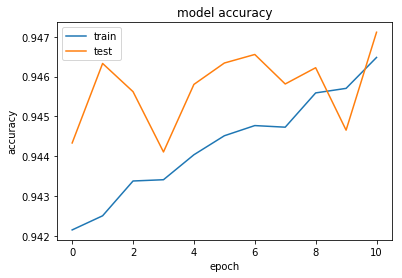

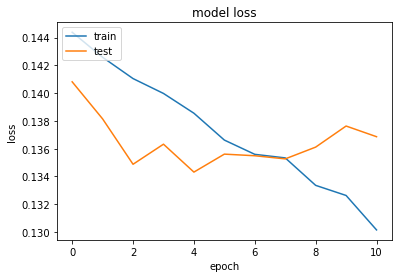

In [42]:
# Plot (preserved) Training History

# summarize history for accuracy
plt.plot(perserved_hist['acc'])
plt.plot(perserved_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(perserved_hist['loss'])
plt.plot(perserved_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()